In [1]:
import numpy as np
import pandas as pd
import ecco_v4_py as ecco
import xarray as xr
from scipy.spatial import KDTree, cKDTree
import swot_ssh_utils as swot
import matplotlib.pyplot as plt
import sys
sys.path.append('/home3/sreich/MITgcm_c68w/MITgcm/utils/python/MITgcmutils')
from MITgcmutils import rdmds

from patchface3D import *
%load_ext autoreload
%autoreload 2

### Read in Grid Data

In [14]:
sNx=30
sNy=30

#grid_dir='/scratch/shoshi/MITgcm_c68p/llc90/run_obsfit_pk0000205956/'
grid_dir='/nobackup/sreich/llc270_c68w_runs/run_pk0000841536_1200s/'
hfc = rdmds(grid_dir+'hFacC', lev=0)
hfc[hfc!=0]=np.nan
# Convert to dict of 5 faces, sizes [(270,90), (270,90), (90,90), (90,270), (90,270)]
hfc_faces = ecco.llc_compact_to_faces(hfc, less_output=True)

xc = rdmds(grid_dir+'XC')
yc = rdmds(grid_dir+'YC')


### Read in SWOT Data

In [5]:
# load swot data

#filename = 'SWOT_L3_LR_SSH_Expert_009_583_20240124T223638_20240124T232805_v1.0.nc'
filename = 'SWOT_L3_LR_SSH_Expert_009_054_20240106T010108_20240106T015234_v1.0.nc'
f2 = 'SWOT_L3_LR_SSH_Expert_009_055_20240106T015235_20240106T024401_v1.0.nc'

if 'L2' in filename:
    pth = '/nobackup/sreich/swot/SWOT_L2_LR_SSH_2.0/Expert/'
elif 'L3' in filename:
    #figure out ftp
    pth = '/nobackup/sreich/swot/L3_aviso/cycle_009/'

ds_swot = xr.open_dataset(pth + filename)

if 'L2' in filename:
    ds_swot = ds_swot.drop_dims('num_sides')
elif 'L3' in filename:
    ds_swot = ds_swot.drop_dims('num_nadir')

ds_swot['longitude'] = (ds_swot['longitude'] + 180) % 360 - 180

# swot_coords = np.c_[ds_swot.latitude.values.ravel(), ds_swot.longitude.values.ravel()]
# swot_coords.shape

ds_swot

<xarray.Dataset>
Dimensions:               (num_lines: 9860, num_pixels: 69)
Coordinates:
    latitude              (num_lines, num_pixels) float64 ...
    longitude             (num_lines, num_pixels) float64 130.5 130.5 ... -62.54
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/16)
    time                  (num_lines) datetime64[ns] ...
    mdt                   (num_lines, num_pixels) float64 ...
    ssha                  (num_lines, num_pixels) float64 ...
    ssha_noiseless        (num_lines, num_pixels) float64 ...
    ssha_unedited         (num_lines, num_pixels) float64 ...
    quality_flag          (num_lines, num_pixels) uint8 ...
    ...                    ...
    ugos                  (num_lines, num_pixels) float64 ...
    vgos                  (num_lines, num_pixels) float64 ...
    ugosa                 (num_lines, num_pixels) float64 ...
    vgosa                 (num_lines, num_pixels) float64 ...
    sigma0                (num_lines, num_pixels) float64 ...
    cross_track_distance  (num_pixels) float64 ...
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    ...                              ...
    time_coverage_begin:             2024-01-06T01:01:08Z
    time_coverage_end:               2024-01-06T01:52:34Z
    geospatial_lat_min:              -78.271903
    geospatial_lat_max:              78.272068
    geospatial_lon_min:              130.546445
    geospatial_lon_max:              297.475895

In [6]:
swot_coords = np.c_[ds_swot.latitude.values.ravel(), ds_swot.longitude.values.ravel()]

swot_coords.shape

(680340, 2)

In [7]:
# apply corrections if using L2 data
if 'L2' in filename:
    ssha = ds_swot.ssha_karin_2
    flag = ds_swot.ancillary_surface_classification_flag
    ssha = np.where(flag == 0, ssha, np.nan)
    
    distance = ds_swot.cross_track_distance.values
    
    ssha = swot.fit_bias(
            ssha, distance,
            check_bad_point_threshold=0.1,
            remove_along_track_polynomial=True
        )

    print(len(ssha[~np.isnan(ssha)]))
    ssha[np.abs(ssha) > 0.3] = np.nan
    print(len(ssha[~np.isnan(ssha)]))
    
    ds_swot.ssha_karin_2.values = ssha
    ds_swot['ssh_processed'] = ds_swot.ssha_karin_2 + ds_swot.mean_dynamic_topography
    
    

In [8]:
# if 'L3' in filename:
#     ds_swot['ssh']

#### nadir already removed?? ####



ssha = ds_swot['ssha'].values

mask = (ds_swot['quality_flag'] == 0).values
ssha = mask * ssha

ssha[np.abs(ssha) > 0.3] = np.nan

len(ssha[~np.isnan(ssha)])


389634

In [9]:
ds_swot['ssh'] = ssha + ds_swot.mdt

ds_swot

<xarray.Dataset>
Dimensions:               (num_lines: 9860, num_pixels: 69)
Coordinates:
    latitude              (num_lines, num_pixels) float64 78.27 78.25 ... -78.27
    longitude             (num_lines, num_pixels) float64 130.5 130.5 ... -62.54
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/17)
    time                  (num_lines) datetime64[ns] ...
    mdt                   (num_lines, num_pixels) float64 ...
    ssha                  (num_lines, num_pixels) float64 nan nan ... nan nan
    ssha_noiseless        (num_lines, num_pixels) float64 ...
    ssha_unedited         (num_lines, num_pixels) float64 ...
    quality_flag          (num_lines, num_pixels) uint8 102 102 102 ... 101 102
    ...                    ...
    vgos                  (num_lines, num_pixels) float64 ...
    ugosa                 (num_lines, num_pixels) float64 ...
    vgosa                 (num_lines, num_pixels) float64 ...
    sigma0                (num_lines, num_pixels) float64 ...
    cross_track_distance  (num_pixels) float64 ...
    ssh                   (num_lines, num_pixels) float64 nan nan ... nan nan
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    ...                              ...
    time_coverage_begin:             2024-01-06T01:01:08Z
    time_coverage_end:               2024-01-06T01:52:34Z
    geospatial_lat_min:              -78.271903
    geospatial_lat_max:              78.272068
    geospatial_lon_min:              130.546445
    geospatial_lon_max:              297.475895

Text(0.5, 1.0, 'SWOT SSH')

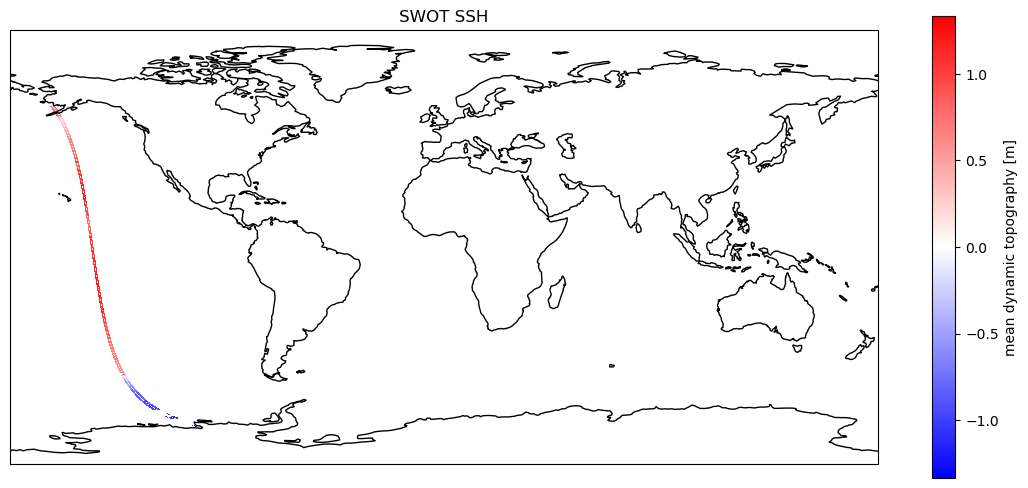

In [11]:
import cartopy
import cartopy.crs as ccrs
cartopy.config['data_dir']='/home3/sreich/.local/share/cartopy'
cartopy.config['pre_existing_data_dir']='/home3/sreich/.local/share/cartopy'

plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds_swot.ssh.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude", cmap='bwr',add_colorbar=True
)
ax.coastlines()
#ax.set_ylim([-60, 30])
#ax.set_xlim([-45,45])
plt.title('SWOT SSH')

### Compute _interp fields

translated from /home/atnguyen/llc270/global/matlab/simple_ctd/

step02:
- xc and yc are reshaped from compact (nx, 13*nx) to worldmap (4*nx, 4*nx)
- prof_point/nearest_swot_index is computed relative to worldmap view
  
step04
- Line 43/44: xc and yc are turned from (4*nx, 4*nx) to 5-face view. Use patchface3D_wrld_to_5f. This is "direction 3" in matlab script patchface3D.m 
- FOR face = 1..5: Do the [X,Y]C[11,NINJ] routine
- Line 68: (I think — convince yourself) sneakily turn each [X,Y]C[11,NINJ] field from 5-face  to compact
- Line 69: Change each field from compact to worldmap (she has done so in her python function)
- Line 70: Use the prof_point (which was created relative to worldmap view) to grab the index from each field, which are now properly in worldmap view.

In [15]:
# step02:

# reshape xc, yc from compact (13*nx, nx) form to worldmap view (nz=1,4*nx, 4*nx)
nx = 270

xc = rdmds(grid_dir+'XC')
yc = rdmds(grid_dir+'YC')

xc = patchface3D(xc,nx,1)
yc = patchface3D(yc,nx,1)

llc_coords = np.c_[yc.ravel(), xc.ravel()]

# compute nearest_swot_index relative to worldmap view
kd_tree = KDTree(llc_coords)
distance, nearest_swot_index_in_llc = kd_tree.query(swot_coords, k=1)



1
(270, 810, 1)
1
(270, 810, 1)


In [33]:
len(nearest_swot_index_in_llc)

680340

1
(270, 810, 1)


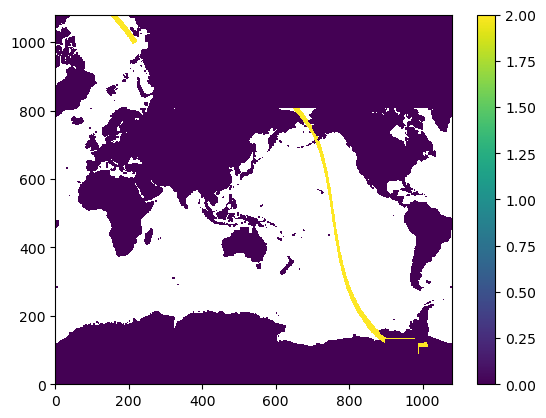

In [16]:
# plot to check 
#grid_dir='/scratch/shoshi/MITgcm_c68p/llc90/run_obsfit_pk0000205956/'
#hfc = rdmds(grid_dir+'hFacC', lev=0)
hfc_wrl = patchface3D(hfc, nx, 1)[0,:,:]
hfc_wrl.ravel()[nearest_swot_index_in_llc]= 2
#plt.pcolor(hfc_wrl*patchface3D(hfc, nx, 1)[0,:,:])
plt.pcolor(hfc_wrl)
plt.colorbar()

In [ ]:
# kd_tree = KDTree(llc_coords)
# import time
# # tic = time.perf_counter()
# # distance, nearest_swot_index_in_llc = kd_tree.query(swot_coords[:200000], k=1)
# # toc = time.perf_counter()
# # print(f"{toc - tic:0.4f} seconds")

# # tic = time.perf_counter()
# # distance, nearest_swot_index_in_llc = kd_tree.query(swot_coords[200000:400000], k=1)
# # toc = time.perf_counter()
# # print(f"{toc - tic:0.4f} seconds")

# tic = time.perf_counter()
# #distance, nearest_swot_index_in_llc = kd_tree.query(swot_coords[370000:380000], k=1)
# distance, nearest_swot_index_in_llc = kd_tree.query(swot_coords, k=1)
# toc = time.perf_counter()
# print(f"{toc - tic:0.4f} seconds")

# ############
# llc_coords.shape, swot_coords.shape
# #swot_coords[370000:380000]
# swot_coords.shape

# #ds_swot.where(~np.isnan(ds_swot.ssha_karin_2), drop=True)
# ############

# #(~np.isnan(ds_swot.ssha_karin_2) * ds_swot.latitude).plot()

# mask = ~np.isnan(ds_swot.ssha_karin_2)
# #mask[mask==0]=np.nan
# #(mask.where(mask==True).values * ds_swot.latitude).plot()


# ~np.isnan(ds_swot.ssha_karin_2) * ds_swot.latitude

# lats = mask.where(mask==True).values * ds_swot.latitude
# lons = mask.where(mask==True).values * ds_swot.longitude

# swot_coords = np.c_[lats.values.ravel(), lons.values.ravel()]

# swot_coords.shape

# ############

# nan_mask = np.isnan(swot_coords).all(axis=1)

# # Invert thef mask to keep rows where at least one element is not nan
# valid_rows = ~nan_mask

# # Filter out rows with nan elements
# cleaned_array = swot_coords[valid_rows]
# cleaned_array.shape




In [17]:
len(nearest_swot_index_in_llc)

680340

In [18]:
### step 4 ###

# transform xc and yc from worldmap (4*nx, 4*nx) to 5-face view
tileCount=0

xgrid = patchface3D_wrld_to_5f(xc)
ygrid = patchface3D_wrld_to_5f(yc)

for i in range(1,6):
    xgrid[i] = np.squeeze(xgrid[i])
    ygrid[i] = np.squeeze(ygrid[i])

XC11=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
YC11=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
XCNINJ=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
YCNINJ=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
iTile=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
jTile=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))
tileNo=dict(zip(range(1,6), [np.zeros_like(xgrid[i]) for i in range(1,6)]))

# FOR face = 1..5: Do the [X,Y]C[11,NINJ] routine
for key in xgrid.keys():
    face_XC = xgrid[key] 
    face_YC = ygrid[key]
    for ii in range(int(face_XC.shape[1]/sNx)):
        for jj in range(int(face_XC.shape[0]/sNy)):
            tileCount += 1
            tmp_i = np.arange(sNx)+sNx*ii
            tmp_j = np.arange(sNy)+sNx*jj
            tmp_XC = face_XC[ np.ix_( tmp_j, tmp_i ) ]
            tmp_YC = face_YC[ np.ix_( tmp_j, tmp_i ) ]
            XC11[key][ np.ix_( tmp_j, tmp_i ) ] = tmp_XC[0,0]
            YC11[key][ np.ix_( tmp_j, tmp_i ) ] = tmp_YC[0,0]
            XCNINJ[key][ np.ix_( tmp_j, tmp_i ) ] = tmp_XC[-1,-1]
            YCNINJ[key][ np.ix_( tmp_j, tmp_i ) ] = tmp_YC[-1,-1]
            iTile[key][ np.ix_( tmp_j, tmp_i ) ] = np.ones((sNx,1)) * np.arange(1,sNy+1)
            jTile[key][ np.ix_( tmp_j, tmp_i ) ] = (np.arange(1,sNx+1) * np.ones((sNy,1))).T
            tileNo[key][ np.ix_( tmp_j, tmp_i ) ] = tileCount*np.ones((sNy,sNx))




In [19]:
tile_keys = ['XC11', 'YC11', 'XCNINJ', 'YCNINJ', 'i', 'j']
tile_vals = [XC11, YC11, XCNINJ, YCNINJ, iTile, jTile]
tile_data_in = dict(zip(tile_keys, tile_vals))
tile_dict = dict()
for key in tile_keys:

    # - Line 68: sneakily turn each [X,Y]C[11,NINJ] field from 5-face  to compact
    temp = tile_data_in[key]
    temp = np.concatenate((temp[1], temp[2], temp[3], temp[4].T, temp[5].T))

    # - Line 69: Change each field from compact to worldmap (she has done so in her python function)
    tile_data_in[key] = patchface3D(temp,nx,1)

    # - Line 70: Use the obs_point (which was created relative to worldmap view) to grab the index from each field, 
    # which are now properly in worldmap view.
    tile_dict['sample_interp_' + key] = tile_data_in[key].ravel()[nearest_swot_index_in_llc]

1
(270, 810, 1)
1
(270, 810, 1)
1
(270, 810, 1)
1
(270, 810, 1)
1
(270, 810, 1)
1
(270, 810, 1)


In [20]:
tile_dict['sample_interp_XC11'].shape, tile_dict

((680340,),
 {'sample_interp_XC11': array([120.14321136, 120.14321136, 120.14321136, ..., -77.83333588,
         -77.83333588, -77.83333588]),
  'sample_interp_YC11': array([ 75.42045593,  75.42045593,  75.42045593, ..., -66.33750153,
         -66.33750153, -66.33750153]),
  'sample_interp_XCNINJ': array([141.60670471, 141.60670471, 141.60670471, ..., -68.16666412,
         -68.16666412, -68.16666412]),
  'sample_interp_YCNINJ': array([ 76.72699738,  76.72699738,  76.72699738, ..., -69.94173431,
         -69.94173431, -69.94173431]),
  'sample_interp_i': array([ 8.,  8.,  8., ..., 21., 21., 21.]),
  'sample_interp_j': array([27., 27., 27., ...,  8.,  8.,  8.])})

### Add obs_interp_ fields to data

In [21]:
# reshape for num_lines, num_pixels
for key in tile_dict.keys():
    tile_dict[key] = tile_dict[key].reshape(ds_swot.ssha.shape)

# add interp fields to xarray
for key, item in tile_dict.items():
    dims = ('num_lines', 'num_pixels')  # Replace with your actual dimension names
    var_da = xr.DataArray(item, dims=dims, name=key)
    ds_swot[key] = var_da

In [28]:
ds_swot['nearest_swot_index_in_llc'] = (('num_lines', 'num_pixels'), nearest_swot_index_in_llc.reshape(9860,69))
ds_swot

<xarray.Dataset>
Dimensions:                    (num_lines: 9860, num_pixels: 69)
Coordinates:
    latitude                   (num_lines, num_pixels) float64 78.27 ... -78.27
    longitude                  (num_lines, num_pixels) float64 130.5 ... -62.54
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/24)
    time                       (num_lines) datetime64[ns] 2024-01-06T01:01:08...
    mdt                        (num_lines, num_pixels) float64 -0.0988 ... -1...
    ssha                       (num_lines, num_pixels) float64 nan nan ... nan
    ssha_noiseless             (num_lines, num_pixels) float64 nan nan ... nan
    ssha_unedited              (num_lines, num_pixels) float64 nan nan ... nan
    quality_flag               (num_lines, num_pixels) uint8 102 102 ... 101 102
    ...                         ...
    sample_interp_YC11         (num_lines, num_pixels) float64 75.42 ... -66.34
    sample_interp_XCNINJ       (num_lines, num_pixels) float64 141.6 ... -68.17
    sample_interp_YCNINJ       (num_lines, num_pixels) float64 76.73 ... -69.94
    sample_interp_i            (num_lines, num_pixels) float64 8.0 8.0 ... 21.0
    sample_interp_j            (num_lines, num_pixels) float64 27.0 27.0 ... 8.0
    nearest_swot_index_in_llc  (num_lines, num_pixels) int64 1076973 ... 121976
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    ...                              ...
    time_coverage_begin:             2024-01-06T01:01:08Z
    time_coverage_end:               2024-01-06T01:52:34Z
    geospatial_lat_min:              -78.271903
    geospatial_lat_max:              78.272068
    geospatial_lon_min:              130.546445
    geospatial_lon_max:              297.475895

In [29]:
len(np.unique(nearest_swot_index_in_llc))

7282

In [35]:
# up until this point, we have obsfit fields for each individual swot point
# now can group and average all swot ssha values in same llc grid square

df_swot = ds_swot.to_dataframe()
gb = df_swot.groupby(['sample_interp_XC11', 'sample_interp_YC11', 'sample_interp_XCNINJ', 'sample_interp_YCNINJ', 'sample_interp_i', 'sample_interp_j'])
counts = gb.size().to_frame(name='counts')
gb_stats = (counts
.join(gb.agg({'ssh': 'mean'}).rename(columns={'ssh': 'obs_val'}))
.join(gb.agg({'ssh': 'std'}).rename(columns={'ssh': 'ssh_std'}))
.join(gb.agg({'latitude': 'mean'}).rename(columns={'latitude': 'sample_y'}))
.join(gb.agg({'latitude': 'std'}).rename(columns={'latitude': 'latitude_std'}))
.join(gb.agg({'longitude': 'mean'}).rename(columns={'longitude': 'sample_x'}))
.join(gb.agg({'longitude': 'std'}).rename(columns={'longitude': 'longitude_std'}))
.join(gb.agg({'time': 'mean'}).rename(columns={'time': 'time_mean'}))
#.join(gb.agg({'idx': 'std'}).rename(columns={'nearest_swot_index_in_llc': 'time_std'}))
.reset_index()
)

gb_stats

,sample_interp_XC11,sample_interp_YC11,sample_interp_XCNINJ,sample_interp_YCNINJ,sample_interp_i,sample_interp_j,counts,obs_val,ssh_std,sample_y,latitude_std,sample_x,longitude_std,time_mean
0,-177.833328,-62.063744,-168.166672,-66.204681,1.0,27.0,5,NaN,NaN,45.882668,0.027575,-154.649835,0.010202,2024-01-06 01:13:24.987624704
1,-177.833328,-62.063744,-168.166672,-66.204681,1.0,28.0,40,0.574667,0.004775,45.718330,0.061348,-154.622428,0.029287,2024-01-06 01:13:27.832675328
2,-177.833328,-62.063744,-168.166672,-66.204681,1.0,29.0,78,0.581393,0.006207,45.509694,0.062974,-154.583790,0.050550,2024-01-06 01:13:31.457046272
3,-177.833328,-62.063744,-168.166672,-66.204681,1.0,30.0,115,0.586252,0.008803,45.293840,0.063216,-154.543951,0.071677,2024-01-06 01:13:35.207084800
4,-177.833328,-57.095081,-168.166672,-61.910133,1.0,1.0,127,0.354008,0.039944,51.328648,0.056538,-157.832613,0.096547,2024-01-06 01:11:43.945604608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6379,172.493179,-74.268501,-176.023346,-77.689720,26.0,26.0,63,1.138560,0.008683,-21.205332,0.081980,-141.960868,0.024832,2024-01-06 01:33:02.493686272
6380,172.493179,-74.268501,-176.023346,-77.689720,26.0,27.0,107,1.128145,0.007092,-21.485720,0.083044,-141.934469,0.038994,2024-01-06 01:33:07.354566400
6381,172.493179,-74.268501,-176.023346,-77.689720,26.0,28.0,148,1.131752,0.008726,-21.768961,0.081714,-141.908172,0.054001,2024-01-06 01:33:12.263642112
6382,172.493179,-74.268501,-176.023346,-77.689720,26.0,29.0,191,1.114971,0.009466,-22.050579,0.082149,-141.883019,0.068897,2024-01-06 01:33:17.141033728


In [32]:
counts

counts
sample_interp_XC11 sample_interp_YC11 sample_interp_XCNINJ sample_interp_YCNINJ sample_interp_i sample_interp_j        
-177.833328        -62.063744         -168.166672          -66.204681           1.0             27.0                  5
                                                                                                28.0                 40
                                                                                                29.0                 78
                                                                                                30.0                115
                   -57.095081         -168.166672          -61.910133           1.0             1.0                 127
...                                                                                                                 ...
 172.493179        -74.268501         -176.023346          -77.689720           26.0            26.0                 63
                                                                                                27.0                107
                                                                                                28.0                148
                                                                                                29.0                191
                                                                                                30.0                234

[6384 rows x 1 columns]

### verify new interpolation gives similar results to old method

In [41]:
gb_stats_old = pd.read_csv('gb_stats_old.csv')
gb_stats_old

gb_stats = gb_stats[~np.isnan(gb_stats['obs_val'])]
gb_stats_old = gb_stats_old[~np.isnan(gb_stats_old['ssha_karin_2_mean'])]

#tmp = np.sort(gb_stats_old.latitude.values) - np.sort(gb_stats.sample_y.values)
#np.nanmin(tmp), np.nanmax(tmp)
np.unique(np.unique(gb_stats.obs_val) - np.unique(gb_stats_old.ssha_karin_2_mean), return_counts=True)

### NOTE: gb_stats_old is llc90 but new is llc1080 eventually check this with same grid ####

ValueError: operands could not be broadcast together with shapes (54474,) (560,) 

## Create obsfit xarray

In [24]:
from datetime import datetime as dt

def datenum(d):
    return 366 + d.toordinal() + (d - dt.fromordinal(d.toordinal())).total_seconds()/(24*60*60)

d = dt.strptime('2023-07-08 23:14:16.622514','%Y-%m-%d %H:%M:%S.%f')
dn = datenum(d)
d, dn

(datetime.datetime(2023, 7, 8, 23, 14, 16, 622514), 739075.9682479458)

In [25]:
gb_stats = gb_stats[~np.isnan(gb_stats['obs_val'])]

gb_stats['obs_date'] = pd.to_datetime(gb_stats['time_mean']).apply(lambda x: datenum(x))
gb_stats['obs_YYYYMMDD'] = gb_stats['time_mean'].apply(lambda x: int(x.strftime('%Y%m%d')))
gb_stats['obs_HHMMSS'] = gb_stats['time_mean'].apply(lambda x: int(x.strftime('%H%M%S')))

gb_stats

/var/tmp/pbs.20703971.pbspl1.nas.nasa.gov/ipykernel_74156/1907508569.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gb_stats['obs_date'] = pd.to_datetime(gb_stats['time_mean']).apply(lambda x: datenum(x))
/var/tmp/pbs.20703971.pbspl1.nas.nasa.gov/ipykernel_74156/1907508569.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gb_stats['obs_YYYYMMDD'] = gb_stats['time_mean'].apply(lambda x: int(x.strftime('%Y%m%d')))
/var/tmp/pbs.20703971.pbspl1.nas.nasa.gov/ipykernel_74156/1907508569.py:5: SettingWithCop

,sample_interp_XC11,sample_interp_YC11,sample_interp_XCNINJ,sample_interp_YCNINJ,sample_interp_i,sample_interp_j,counts,obs_val,ssh_std,sample_y,latitude_std,sample_x,longitude_std,time_mean,obs_date,obs_YYYYMMDD,obs_HHMMSS
1,-177.833328,-62.063744,-168.166672,-66.204681,1.0,28.0,40,0.574667,0.004775,45.718330,0.061348,-154.622428,0.029287,2024-01-06 01:13:27.832675328,739257.051017,20240106,11327
2,-177.833328,-62.063744,-168.166672,-66.204681,1.0,29.0,78,0.581393,0.006207,45.509694,0.062974,-154.583790,0.050550,2024-01-06 01:13:31.457046272,739257.051059,20240106,11331
3,-177.833328,-62.063744,-168.166672,-66.204681,1.0,30.0,115,0.586252,0.008803,45.293840,0.063216,-154.543951,0.071677,2024-01-06 01:13:35.207084800,739257.051102,20240106,11335
4,-177.833328,-57.095081,-168.166672,-61.910133,1.0,1.0,127,0.354008,0.039944,51.328648,0.056538,-157.832613,0.096547,2024-01-06 01:11:43.945604608,739257.049814,20240106,11143
5,-177.833328,-57.095081,-168.166672,-61.910133,1.0,2.0,129,0.324260,0.039909,51.130338,0.057687,-157.830479,0.096422,2024-01-06 01:11:47.243140864,739257.049852,20240106,11147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6379,172.493179,-74.268501,-176.023346,-77.689720,26.0,26.0,63,1.138560,0.008683,-21.205332,0.081980,-141.960868,0.024832,2024-01-06 01:33:02.493686272,739257.064612,20240106,13302
6380,172.493179,-74.268501,-176.023346,-77.689720,26.0,27.0,107,1.128145,0.007092,-21.485720,0.083044,-141.934469,0.038994,2024-01-06 01:33:07.354566400,739257.064668,20240106,13307
6381,172.493179,-74.268501,-176.023346,-77.689720,26.0,28.0,148,1.131752,0.008726,-21.768961,0.081714,-141.908172,0.054001,2024-01-06 01:33:12.263642112,739257.064725,20240106,13312
6382,172.493179,-74.268501,-176.023346,-77.689720,26.0,29.0,191,1.114971,0.009466,-22.050579,0.082149,-141.883019,0.068897,2024-01-06 01:33:17.141033728,739257.064782,20240106,13317


In [26]:
obs_weight = np.ones(len(gb_stats.sample_y.values))

obs = xr.Dataset(
    data_vars=dict(
        obs_date           =(["iOBS"], gb_stats.obs_date.values),
        obs_YYYYMMDD       =(["iOBS"], gb_stats.obs_YYYYMMDD.values),
        obs_HHMMSS         =(["iOBS"], gb_stats.obs_HHMMSS.values), 
        sample_x           =(["iSAMPLE"], gb_stats.sample_x.values),
        sample_y           =(["iSAMPLE"], gb_stats.sample_y.values),
        sample_z           =(["iSAMPLE"], np.zeros(len(gb_stats.sample_y.values))),
        sample_type        =(["iSAMPLE"], 5*np.ones(len(gb_stats.sample_y.values))),
        obs_val            =(["iOBS"], gb_stats.obs_val.values),
        obs_uncert         =(["iOBS"], np.sqrt(1/obs_weight)),
        sample_interp_XC11 =(["iOBS"], gb_stats.sample_interp_XC11.values ),
        sample_interp_YC11 =(["iOBS"], gb_stats.sample_interp_YC11.values ),
        sample_interp_XCNINJ =(["iOBS"], gb_stats.sample_interp_XCNINJ.values ),
        sample_interp_YCNINJ =(["iOBS"], gb_stats.sample_interp_YCNINJ.values ),
        sample_interp_i =(["iOBS"], gb_stats.sample_interp_i.values ),
        sample_interp_j =(["iOBS"], gb_stats.sample_interp_j.values ),
        sample_interp_w =(["iOBS", "iINTERP"], np.ones((len(gb_stats.sample_interp_i),8))/8  )
    ),
)

In [27]:
obs = obs.assign_coords({'longitude': obs.sample_x, 'latitude': obs.sample_y})
obs

<xarray.Dataset>
Dimensions:               (iOBS: 2960, iSAMPLE: 2960, iINTERP: 8)
Coordinates:
    longitude             (iSAMPLE) float64 -154.6 -154.6 ... -141.9 -141.9
    latitude              (iSAMPLE) float64 45.72 45.51 45.29 ... -22.05 -22.33
Dimensions without coordinates: iOBS, iSAMPLE, iINTERP
Data variables: (12/16)
    obs_date              (iOBS) float64 7.393e+05 7.393e+05 ... 7.393e+05
    obs_YYYYMMDD          (iOBS) int64 20240106 20240106 ... 20240106 20240106
    obs_HHMMSS            (iOBS) int64 11327 11331 11335 ... 13312 13317 13322
    sample_x              (iSAMPLE) float64 -154.6 -154.6 ... -141.9 -141.9
    sample_y              (iSAMPLE) float64 45.72 45.51 45.29 ... -22.05 -22.33
    sample_z              (iSAMPLE) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                    ...
    sample_interp_YC11    (iOBS) float64 -62.06 -62.06 -62.06 ... -74.27 -74.27
    sample_interp_XCNINJ  (iOBS) float64 -168.2 -168.2 -168.2 ... -176.0 -176.0
    sample_interp_YCNINJ  (iOBS) float64 -66.2 -66.2 -66.2 ... -77.69 -77.69
    sample_interp_i       (iOBS) float64 1.0 1.0 1.0 1.0 ... 26.0 26.0 26.0 26.0
    sample_interp_j       (iOBS) float64 28.0 29.0 30.0 1.0 ... 28.0 29.0 30.0
    sample_interp_w       (iOBS, iINTERP) float64 0.125 0.125 ... 0.125 0.125

In [47]:
data_dir = '/nobackup/sreich/swot/swot_obsfit_L2/'
fname = filename.split('.')[0] + '_obsfit.nc'
#obs.to_netcdf(data_dir + fname)

In [51]:
obsfit_nc = xr.open_dataset(data_dir + fname)
obsfit_nc.obs_val.values

array([-0.16523782, -0.18643998, -0.16684487, ...,  0.26722322,
        0.26269836,  0.25008466])

In [3]:
import numpy as np
import pandas as pd
import ecco_v4_py as ecco
import xarray as xr
from scipy.spatial import KDTree
import swot_ssh_utils as swot
import sys
sys.path.append('/home3/sreich/MITgcm_c68w/MITgcm/utils/python/MITgcmutils')
from MITgcmutils import rdmds

from patchface3D import *

### Load in LLC Grid ###

sNx = 180
sNy=sNx

grid_dir='/nobackup/sreich/llc1080_c68w_runs/run/'
hfc = rdmds(grid_dir+'hFacC', lev=0)
hfc[hfc!=0]=np.nan
# Convert to dict of 5 faces, sizes [(270,90), (270,90), (90,90), (90,270), (90,270)]
hfc_faces = ecco.llc_compact_to_faces(hfc, less_output=True)

xc = rdmds(grid_dir+'XC')
yc = rdmds(grid_dir+'YC')



### Read in SWOT Data from Input Args ###

pth = '/nobackup/sreich/swot/SWOT_L2_LR_SSH_2.0/Expert/'
filename = 'SWOT_L2_LR_SSH_Expert_009_001_20240104T033426_20240104T042554_PIC0_01.nc' # sys.argv[0] is name of python file


ds_swot = xr.open_dataset(pth + filename)
ds_swot = ds_swot.drop_dims('num_sides')
ds_swot['longitude'] = (ds_swot['longitude'] + 180) % 360 - 180

ds_swot_sub = ds_swot.where(ds_swot.ancillary_surface_classification_flag == 0, drop=True)
swot_coords = np.c_[ds_swot_sub.latitude.values.ravel(), ds_swot_sub.longitude.values.ravel()]

# apply corrections
ssha = ds_swot_sub.ssha_karin_2
flag = ds_swot_sub.ancillary_surface_classification_flag
ssha = np.where(flag == 0, ssha, np.nan)

distance = ds_swot_sub.cross_track_distance.values

ssha = swot.fit_bias(
        ssha, distance,
        check_bad_point_threshold=0.1,
        remove_along_track_polynomial=True
    )

ds_swot_sub.ssha_karin_2.values = ssha

ssha[np.abs(ssha) > 0.3] = np.nan
ds_swot_sub.ssha_karin_2.values = ssha



In [4]:
### Compute _interp fields ###

# reshape xc, yc from compact (13*nx, nx) form to worldmap view (nz=1,4*nx, 4*nx)
nx = 1080

xc = rdmds(grid_dir+'XC')
yc = rdmds(grid_dir+'YC')

xc = patchface3D(xc,nx,1)
yc = patchface3D(yc,nx,1)

llc_coords = np.c_[yc.ravel(), xc.ravel()]

1
(1080, 3240, 1)
1
(1080, 3240, 1)


# Change dates to 1992

In [2]:
swot_dir = '/nobackup/sreich/swot/swot_obsfit_L3/'
#ds_swot_test = xr.open_dataset(swot_dir + 'swot_cycles_009_llc270_30_test_obsfit.nc')
#ds_swot = xr.open_dataset(swot_dir + 'swot_cycles_009_llc270_30_obsfit.nc')
ds_swot = xr.open_dataset(swot_dir + 'swot_cycles_009_llc90_30_test_obsfit.nc')

ds_swot

<xarray.Dataset>
Dimensions:               (iOBS: 270303, iSAMPLE: 270303, iINTERP: 8)
Dimensions without coordinates: iOBS, iSAMPLE, iINTERP
Data variables: (12/16)
    obs_date              (iOBS) float64 ...
    obs_YYYYMMDD          (iOBS) int64 ...
    obs_HHMMSS            (iOBS) int64 ...
    sample_x              (iSAMPLE) float64 ...
    sample_y              (iSAMPLE) float64 ...
    sample_z              (iSAMPLE) float64 ...
    ...                    ...
    sample_interp_YC11    (iOBS) float64 ...
    sample_interp_XCNINJ  (iOBS) float64 ...
    sample_interp_YCNINJ  (iOBS) float64 ...
    sample_interp_i       (iOBS) float64 ...
    sample_interp_j       (iOBS) float64 ...
    sample_interp_w       (iOBS, iINTERP) float64 ...

In [3]:
ds_swot.obs_date.values

array([739257.08000941, 739257.08005271, 739257.0802049 , ...,
       739264.66771738, 739264.66752372, 739264.66733284])

In [4]:
from datetime import datetime as dt

def datenum(d):
    return 366 + d.toordinal() + (d - dt.fromordinal(d.toordinal())).total_seconds()/(24*60*60)

d = dt.strptime('2023-07-08 23:14:16.622514','%Y-%m-%d %H:%M:%S.%f')
dn = datenum(d)
d, dn

(datetime.datetime(2023, 7, 8, 23, 14, 16, 622514), 739075.9682479458)

In [6]:
# change to 1992
ds_swot['obs_YYYYMMDD'] = ds_swot['obs_YYYYMMDD'] - 320000

# fix obs_date

date = ds_swot['obs_YYYYMMDD'].astype(int).astype(str)  # Convert date to string format 'YYYYMMDD'
time = ds_swot['obs_HHMMSS'].astype(int).astype(str).str.zfill(6)  # Convert time to string format

datetime_str = pd.Series(date.values) + pd.Series(time.values)

# Convert combined strings to datetime
datetime = pd.to_datetime(datetime_str, format='%Y%m%d%H%M%S')
obs_datetime = datetime.apply(lambda x: datenum(x))

obs_datetime.values

ds_swot['obs_date'] = ds_swot['obs_date']*0 + obs_datetime.values
ds_swot

<xarray.Dataset>
Dimensions:               (iOBS: 270303, iSAMPLE: 270303, iINTERP: 8)
Dimensions without coordinates: iOBS, iSAMPLE, iINTERP
Data variables: (12/16)
    obs_date              (iOBS) float64 7.276e+05 7.276e+05 ... 7.276e+05
    obs_YYYYMMDD          (iOBS) int64 19920106 19920106 ... 19920113 19920113
    obs_HHMMSS            (iOBS) int64 ...
    sample_x              (iSAMPLE) float64 ...
    sample_y              (iSAMPLE) float64 ...
    sample_z              (iSAMPLE) float64 ...
    ...                    ...
    sample_interp_YC11    (iOBS) float64 ...
    sample_interp_XCNINJ  (iOBS) float64 ...
    sample_interp_YCNINJ  (iOBS) float64 ...
    sample_interp_i       (iOBS) float64 ...
    sample_interp_j       (iOBS) float64 ...
    sample_interp_w       (iOBS, iINTERP) float64 ...

In [8]:
ds_swot.obs_date.values

array([727569.08      , 727569.0800463 , 727569.08019676, ...,
       727576.66770833, 727576.66752315, 727576.66732639])

In [10]:
ds_swot.to_netcdf(swot_dir + 'swot_cycles_009_llc90_30_1992_obsfit.nc')

In [19]:
ds_swot_test = ds_swot.isel(iOBS=range(0,50000), iSAMPLE=range(0,50000))
ds_swot_test.to_netcdf(swot_dir + 'swot_cycles_009_llc90_30_test_1992_obsfit.nc')

In [16]:
[1]

1